# Bayesian model mixing: a sandbox of possibilities

## Written by: Alexandra Semposki

### Date: 16 August 2021

Here in this notebook I have constructed an interactive example of the Bayesian model mixing toy model project I have been working on for the summer of 2021. Let's first begin with some background mathematics to describe the problem at hand.

Suppose I have a function, such as the one below, which can be described as the zero-dimensional $\phi^{4}$ theory partition function:

$$
F(g) = \int_{-\infty}^{\infty} dx ~ e^{\frac{-x^{2}}{2} - g^{2}x^{4}} = \frac{e^{\frac{1}{32 g^{2}}}}{2 \sqrt{2} g} K_{\frac{1}{4}} \left( \frac{1}{32 g^{2}} \right)
$$

where $K$ is the modified Bessel function of the second kind. We want to expand this function in the limits of low $g$ and high $g$, specifically $g = 0$ and $g = \infty$. The expansions are below. For $g = 0$, 

$$
F_{s}^{(N_{s})} (g) = \sum_{k = 0}^{N_{s}} s_{k} g^{k},
$$

where 

$$
s_{2k + 1} = 0,
$$

and

$$
s_{2k} = \frac{\sqrt{2}~ \Gamma{(2k + 1/2)}}{k!}(-4)^{k}.
$$

$N_{s}$ is the highest order we will specify for our series. 

For $g = \infty$, 

$$
F_{l}^{(N_{l})} (g) = \frac{1}{\sqrt{g}} \sum_{k = 0}^{N_{l}} l_{k} g^{-k}, 
$$

where 

$$
l_{k} = \frac{\Gamma{\left(\frac{k}{2} + \frac{1}{4}\right)}}{2k!} \left(-\frac{1}{2}\right)^{k}.
$$

The two expansions above represent some models we have been able to obtain from the "data" that we collected in the lab. Now we want to see what these expansions look like in a plot. This will depend on which value of $k$ we choose for which expansion. Let's pick $k$ = 5 for the small-$g$ expansion and $k$ = 23 for the large-$g$ expansion.

In [1]:
#import necessary packages
import numpy as np
import math
import emcee
import corner
from cycler import cycler
from scipy import stats, special, integrate

import matplotlib.pyplot as plt
%matplotlib inline

#import classes we'll need
from mixing import Switching, Mixing
from discrepancy import Discrepancy
from priors import Priors

First we will make a class object:

In [2]:
new = Mixing()

Welcome to the BMM sandbox! Here you get to play!


Now we can look at the functions of the class to see what we will need to plot the expansions we want. 

In [3]:
dir(Mixing)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_select_function',
 'add_data',
 'burnin_trace',
 'cdf',
 'credible_intervals',
 'high_g',
 'likelihood_high',
 'likelihood_low',
 'logistic',
 'low_g',
 'lpdf',
 'luniform',
 'mixed_model',
 'plot_data',
 'plot_models',
 'plot_ppd',
 'ppd',
 'residuals',
 'sampler_mix',
 'stats_trace',
 'switchcos',
 'true_model']

From here, it looks like we want the 'plot_models' function. Let's start with that. We run the 'help()' command to see what inputs that function needs.

In [4]:
help(Mixing.plot_models)

Help on function plot_models in module mixing:

plot_models(self, g, loworder, highorder)
    A plotting function to produce a figure of the model expansions calculated in Mixing.low_g and Mixing.high_g, 
    and including the true model calculated using Mixing.true_model.
    
    :Example:
        Mixing.plot_models(g=np.linspace(0.0, 0.5, 100), lowk=np.array([5, 23]), highk=np.array([5, 23]))
        
    Parameters:
    -----------
    g : linspace
        The linspace in on which the models will be plotted here. 
    
    loworder : int, float     
        As in Mixing.low_g, the highest powers to calculate the series to for the asymptotic small-g expansion.
    
    highorder : int, float        
        As in Mixing.high_g, the highest powers to calculate the series to for the convergent large-g expansion.
        
    Returns
    -------
    None.



We now can set up the necessary parameters, using the example given in the plot_models function docstring.

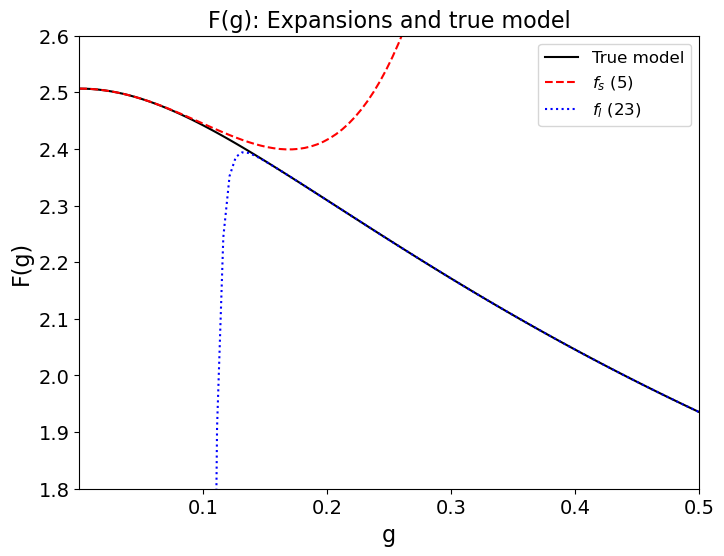

In [5]:
g = np.linspace(1e-6, 0.5, 100)
lowk = np.array([5])
highk = np.array([23])

new.plot_models(g, lowk, highk)

Because this is a toy model, we can calculate the true model (the partition function in full form as shown mathematically above) and compare to the expansions. 

## Mixing method 1: the linear mixture model

There are two different methods that we can implement when it comes to mixing these expansions. We'll explore the linear mixture formulation first.

Now we would like to generate some data from this true model and see what we can do with it. 

Data will be generated. What percent error would you like on your data (please enter a decimal)?0.01


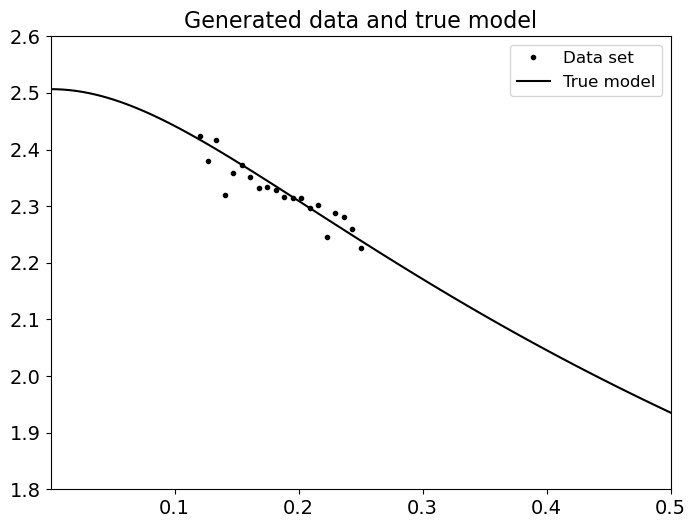

In [6]:
g_data = np.linspace(0.12, 0.25, 20)

data, sigma = new.add_data(g, g_data)

Now that we have some data to work with, we would like to take our two models and see if we can mix them in a way that will match the true model as much as possible, without being too informed of what it should look like. First, we need to assess what kind of model mixing we will be doing---in our case, we'll try a simple linear mixture model. This can be described mathematically as follows. The likelihood in such a mixing model is given generally as:

$$
p(\mathbf{y}|\theta_{1}, \theta_{2}) = \prod_{i=1}^{n} \left\{ f(x_{i}) \left[ \left(\frac{1}{\sqrt{2 \pi} \sigma} \right) \exp\left(\frac{y_{i} - f_{1}(\theta_{1}, x_{i})}{2 \sigma^{2}}\right) \right] + (1 - f(x_{i})) \left[ \left(\frac{1}{\sqrt{2 \pi} \sigma} \right) \exp\left(\frac{y_{i} - f_{2}(\theta_{2}, x_{i})}{2 \sigma^{2}}\right) \right] \right\}
$$

According to Bayes' theorem, the posterior of a distribution is given by the likelihood multiplied by the prior, as below:

$$
p(\theta|d) = p(d|\theta)p(\theta),
$$

so we'll need a prior distribution for each parameter, $\theta$, that we need to determine. The number of parameters depends on the switching function, $f(x)$, we choose.

We will also need to take the logarithm of Bayes' theorem for the parameter estimation to work well here, so we'll obtain:

$$
\log(p(\theta|d)) = \log(p(d|\theta)) + \log(p(\theta)).
$$

Let's look at the switching functions available to us. 

In [7]:
dir(Switching)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'cdf',
 'logistic',
 'plot_ppd',
 'ppd',
 'switchcos']

This shows only 3: 'cdf', 'logistic', and 'switchcos'. Let's use the cosine one.

In [8]:
help(Switching.switchcos)

Help on function switchcos in module mixing:

switchcos(self, params, g)
    A piecewise function using two constants at either end, and two cosine functions in the centre,
    to be used as a switching function. One free parameter, g3, is found by sampling. 
    
    :Example:
        Switching.switchcos(params=np.array(), g=0.5)
        
    Parameters:
    -----------
    params : numpy.ndarray
        The array of parameters to be determined by the sampler (here labelled g1, g2, and g3, where
        g1 is the separation point between the first constant function and the first cosine function, 
        g2 is the separation point between the second cosine function and the second constant function, 
        and g3 is the point between the two cosine functions). 
    
    g : float
        The value of g that this cosine function is calculated at.
    
    Returns:
    --------
        The value of the function at a specific point in g.



Let's look at what this function is supposed to look like across $g$ space, given some parameter guesses. 

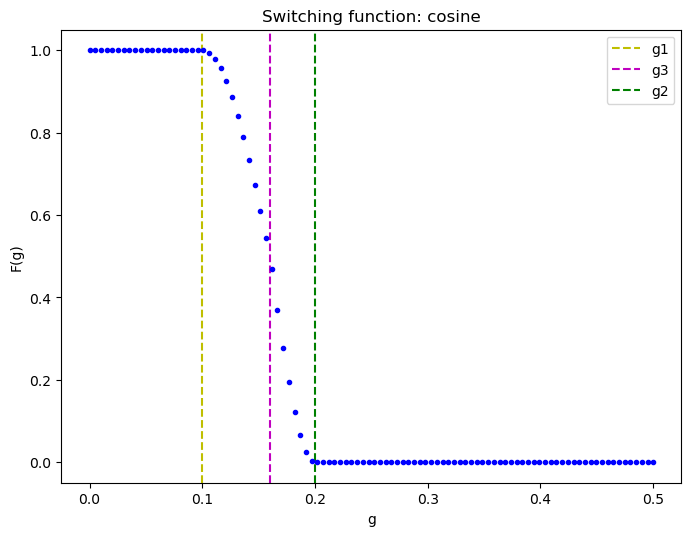

In [9]:
fig = plt.figure(figsize=(8,6), dpi=100)
ax = plt.axes()
ax.set_xlabel('g')
ax.set_ylabel('F(g)')
ax.set_title('Switching function: cosine')
ax.axvline(x=0.1, color='y', linestyle='dashed', label='g1')
ax.axvline(x=0.16, color='m', linestyle='dashed', label='g3')
ax.axvline(x=0.2, color='g', linestyle='dashed', label='g2')

for i in range(len(g)):
    ax.plot(g[i], new.switchcos(np.array([0.1, 0.2, 0.16]), g[i]), 'b.')

ax.legend()

Now we are ready to determine some priors for g1, g2, and g3. These must be set by the user, and are already done in the file priors.py, which can be accessed [here](./priors.py).

In this file, we have preset the priors to be normally distributed for each parameter, with the means equal to 0.11, 0.16, and 0.2 (g1, g3, and g2, respectively), with standard deviations of 0.01 each. This is a VERY precise standard deviation, which we will get to later on. 

Now, let's call the mixing model. 

In [10]:
trace = new.mixed_model(g_data, data, sigma, lowk, highk)

What switching function would you like to use: logistic, cdf, or cosine?cosine
Using 10 walkers with 1500 steps each, for a total of 15000 samples.
[[0.11353529 0.19118923 0.14003701]
 [0.10106489 0.17387888 0.15108054]
 [0.1241172  0.178012   0.14403184]
 [0.1234228  0.19486069 0.15973098]
 [0.10564201 0.18684926 0.14121458]
 [0.12128002 0.18769816 0.15231688]
 [0.11137131 0.19348719 0.14745703]
 [0.1070468  0.17395783 0.1484836 ]
 [0.11540226 0.17056879 0.15300471]
 [0.11991886 0.17897868 0.15831227]] (10, 3)
Calculation finished!
Duration = 1 min, 44 sec.
How many burn-in samples per walker?200
Using 200 samples as burn-in, for a total of 2000 burn-in samples.
(10, 1500, 3)
(3, 13000)


(3, 13000)
Do you want to display the median with the mean? (yes/no)yes


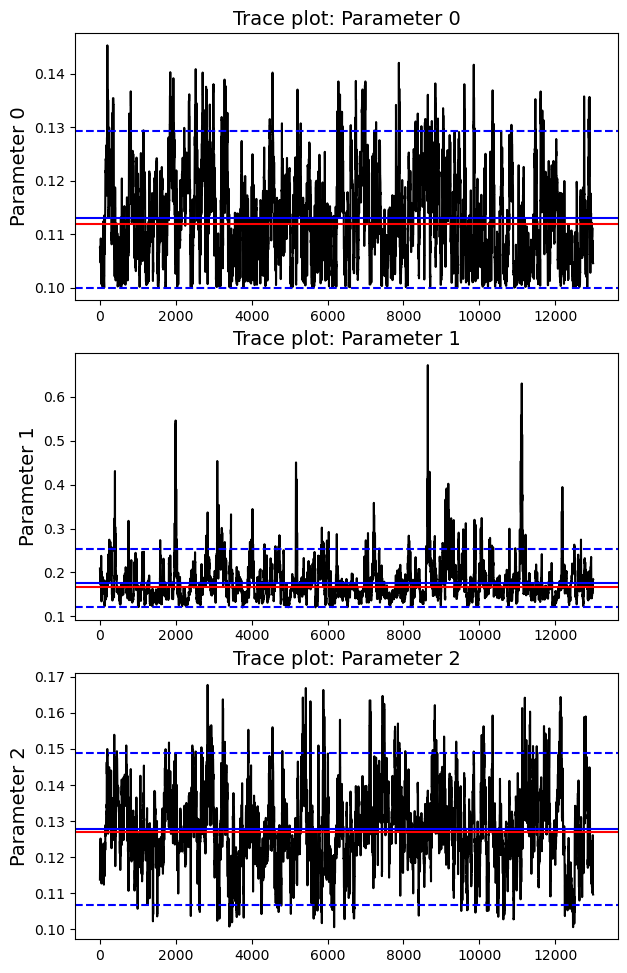

Mean results:  [0.11303476 0.17695437 0.12767055]


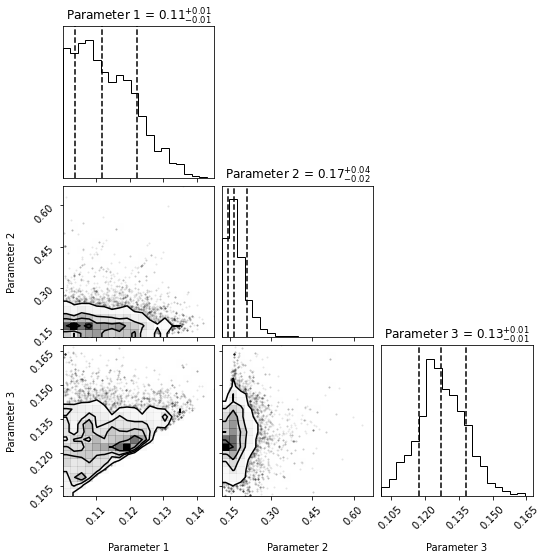

In [11]:
mean, intervals = new.stats_trace(trace, len(trace))

print('Mean results: ', mean)

We can see from the traces above that the parameters look pretty well sampled. We can now use our results in calculating the posterior predictive distribution (PPD) for the mixed model. We will plot the mean and the credible intervals of the PPD along with our data and individual models to see how it looks.

In [12]:
switch_results_ppd = new.ppd(trace, g, lowk, highk)

switch_mean_results = np.empty([len(g)])
switch_g_intervals = np.empty([len(g), 2])

for i in range(len(g)):
    switch_mean_results[i] = np.mean(switch_results_ppd[i,:])
    switch_g_intervals[i, :] = new.credible_intervals(switch_results_ppd[i,:], 0.95)

Enter the minimum g to plot.0.05
Enter the maximum g to plot.0.25
Enter the minimum for F(g).1.8
Enter the maximum for F(g).2.6


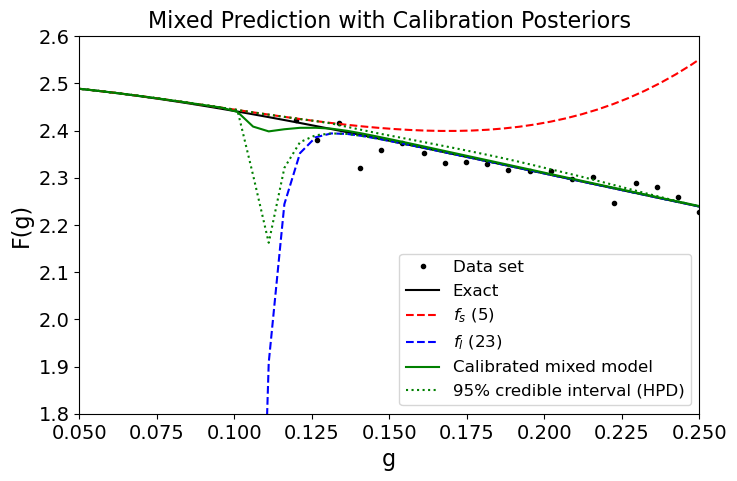

Would you like to save the plot to a file (yes/no)?no


In [13]:
new.plot_ppd(g_data, g, g, data, switch_mean_results, switch_g_intervals, 95, lowk, highk)

Now we have a plot of our results!

Some issues, however, with this model so far:
- The priors need to be __very__ narrow for the sampler to get a reasonable estimate of the parameters. Essentially, we have the problem of needing to already know the true model before we mix.
- The dip of the credible intervals on the left hand side of the plot still shows a tendency for the mixed model to follow the blue curve near that end. We may need more than two models to mix for this region to become smooth. 

__Next step__: We will soon be adding the model discrepancies to the expansion models to see if this will make our mixed model more robust.

## Mixing method 2: modelling discrepancies

We will now explore a different method of model mixing which bypasses the generation of data altogether, favouring the approach that the expansions were created from lab data themselves. In this case, we'll also see the inclusion of variances on the expansion models, which, in retrospect, makes much more sense than having them act as delta functions, as in the last method.

First, we need to think about how to set up an error model: we have two expansions in power series form, just as before. How do we imagine the error will look? A reasonable guess would be the next order in the series:

$$
f(x) = \sum_{n=0}^{N} c_{n} g^{n} \simeq c_{0} + c_{1} g + c_{2} g^{2} + c_{3} g^{3} + ... + c_{n} g^{n} + \mathcal{O}^{n + 1}
$$

We need to find the form of $\mathcal{O}^{n+1}$. We know, regarding this general power series, that it will be $c_{n+1} g^{n+1}$, but we do not know the form of the coefficient here. It is our first task to determine this.

We could go through the entire procedure step by step here, but for now let's shorten that and just say that we are going to pick the following two variance models for the two expansions:

$$
v_{1}^{(2n)} = \bar{c}^{2} (2n + 2)!^{2} g^{4n + 4},
$$

and

$$
v_{2}^{(m)} = \bar{d}^{2} (m + 1)!^{-2} g^{-2m - 2},
$$

where $m$ and $n$ are the different orders we are taking for the expansions, and $\bar{c}$, $\bar{d}$ represent the parts of the coefficients that come from the original known coefficients in the expansion. The important thing to remember here is that the expansion's form would not be totally known to someone building the expansion models out of the lab data, so we need to estimate the next coefficient from the previous ones. 

To find $\bar{c}$ and $\bar{d}$, we take the rms of the previous coefficients. 

Now we are going to combined our models in the following manner and calculate the mean and credible intervals, much in the same way as the linear mixture. The posterior distribution here is given by:

$$
f_{\dagger} = \mathcal{N}\left(\frac{v_{2} f_{1} + v_{1} f_{2}}{v_{1} + v_{2}}, \frac{v_{1} v_{2}}{v_{1} + v_{2}} \right)
$$

[ 2.50662827 -3.75994241  5.48324935 -6.03157429  5.25070083 -3.76883637]
4.630339275906615
[ 1.81280495 -0.30635418  0.11330031 -0.05744141  0.03540635 -0.02513062]
0.752566311067675


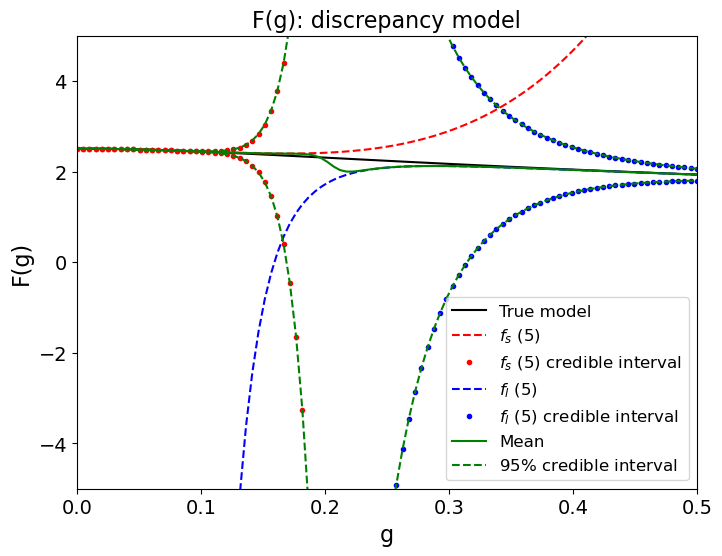

In [14]:
#set new orders
low = np.array([5])
high = np.array([5])

disc = Discrepancy()

pdf = disc.fdagger(g, low, high)

From the plot above, we can see that the discrepancy model (in green) is doing well in the centre, between the two models. It is not jumping around or discontinuously connecting the two models across the space. The credible intervals get really large in the centre, which we also expect since the variances of the expansions will open to envelope more range around the gap between the two models. At the ends, however, it works very well, which we were hoping for. 

Now let's plot some of the expansions and see if the next order in the expansion model fits within the error bands on the previous order.

[ 2.50662827 -3.75994241  5.48324935 -6.03157429  5.25070083 -3.76883637]
4.630339275906615
[ 1.81280495 -0.30635418  0.11330031 -0.05744141  0.03540635 -0.02513062]
0.752566311067675


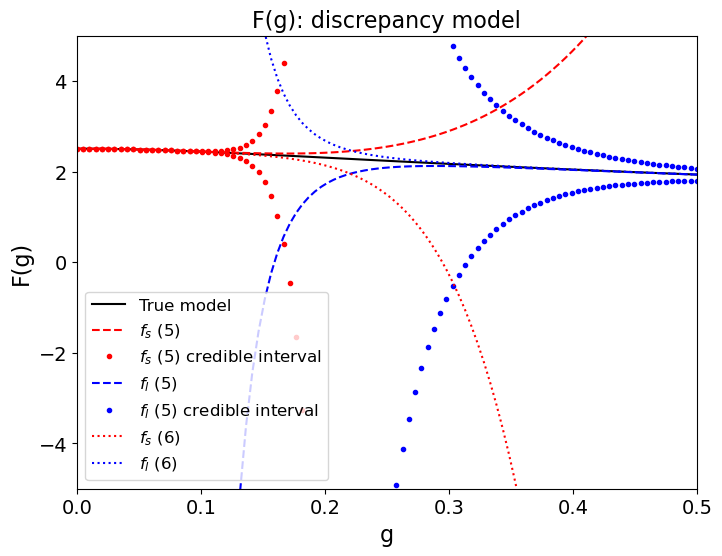

In [15]:
#set new orders
low = np.array([5])
high = np.array([5])

pdf = disc.fdagger(g, low, high, plot_fdagger=False, next_order=True)

This all leads to the questions we addressed before: how to make the mixed model predict more accurately in the centre between the two expansions. We will continue this project to look at having GPs in the centre and using data, or doing some more work with the error model here so that it does a better job. There are many threads to follow here!